<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
# Для начала я загурзил файлы с google disk'а
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Разорхируем архив =)
!unzip -q /content/gdrive/MyDrive/archive.zip

In [ ]:
# Проверка на то, дествительно ли все распоковалось
!ls

faces_dataset_small  gdrive  sample_data


#### Так как картинки лежат в директории faces_dataset_small, а мне надо чтобы в этой директории был класс (папка) с картинками то я написал мини-скрипт, который создаст в директории faces_dataset_small новую потдиректорию, в которую перенесет картинки

#### P.S. Функция ImageFolder жаловалась, что не видет классы в директории faces_dataset_small, и в виду своей не опытности я не знаю что нужно передать в ImageFolder, чтобы она считывала файлы с одной директории как один класс, поэтому написал мини-костыль, надеюсь я не дурак =)

In [ ]:
import os
import shutil

source_directory = 'faces_dataset_small'
destination_directory = 'faces_dataset_small/faces'

# Создание директории faces
os.makedirs(destination_directory, exist_ok=True)

# Получение списка файлов
files = os.listdir(source_directory)

# Перемещение файлов в новую директорию faces
for file in files:
    source_path = os.path.join(source_directory, file)
    destination_path = os.path.join(destination_directory, file)
    if os.path.isfile(source_path):
        shutil.move(source_path, destination_path)

# Удаление оставшихся файлов и исходной директории faces_dataset_small
for file in os.listdir(source_directory):
    file_path = os.path.join(source_directory, file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
    except Exception as e:
        print(f"Не удалось удалить файл {file_path}: {e}")

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

def get_dataloader(image_size, batch_size, device, dataset_path='faces_dataset_small'):
    """
    Строит DataLoader для тренировочных данных.
    Использует tt.Compose и tt.Resize для преобразований.
    :param image_size: высота и ширина изображения
    :param batch_size: размер пакета DataLoader
    :param device: устройство, на которое нужно передать данные (например, 'cuda' для GPU)
    :param dataset_path: путь к директории с данными
    :returns: объект DataLoader
    """
    # Меняем разрмер изображений
    data_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ])

    # Создаем набор данных с помощью ImageFolder
    dataset = ImageFolder(root=dataset_path, transform=data_transform)

    # Данные пихаем в DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Передача DataLoader на GPU
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=(device=='cuda'))

    return dataloader

In [ ]:
image_size = 128
batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataloader = get_dataloader(image_size, batch_size, device)

#### Выведем пару картинок для того чтобы посмотреть что все хорошо

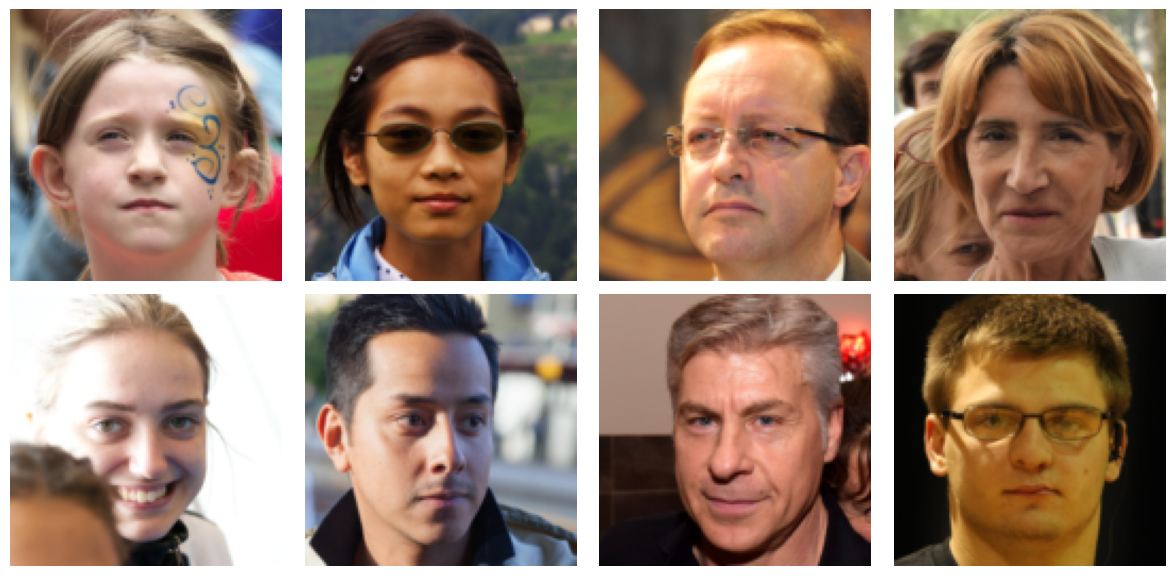

In [ ]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

def imshow(images, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for i, ax in enumerate(axes.flat):
        if images[i].shape[0] == 1:
            img = np.array(images[i][0])
        else:
            img = np.array(images[i].permute(1, 2, 0))

        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Получение одного батча
for batch in dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    imshow(inputs.cpu(), rows=2, cols=4)
    break

##### Угарные картинки конечно =)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
# Создадим класс дискриминатора по условиям задания
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # in: 3 x 128 x 128

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 8 x 8

            nn.Conv2d(512, 1, kernel_size=7, stride=2, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


discriminator = Discriminator(image_size=128)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # вход: latent_size x 1 x 1

            nn.ConvTranspose2d(latent_size, 512, kernel_size=8, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # выход: 512 x 8 x 8

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # выход: 256 x 16 x 16

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # выход: 128 x 32 x 32

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # выход: 64 x 64 x 64

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # выход: 3 x 128 x 128
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)
        return self.model(x)

# Создание генератора
latent_size = 128
generator = Generator(latent_size, image_size=128)

In [ ]:
from torchsummary import summary
model = Discriminator(128).to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12              [-1, 1, 1, 1]          25,088
          Flatten-13                    [-1, 1]               0
          Sigmoid-14                   

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0002

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": torch.nn.BCELoss(),
    "generator": torch.nn.BCELoss()
}

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

In [ ]:
from torchvision.utils import save_image, make_grid
def save_samples(index, latent_tensors, show=True):

    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images, nrow=8).permute(1, 2, 0))

torch.Size([64, 3, 128, 128])
torch.Size([64, 3, 128, 128])


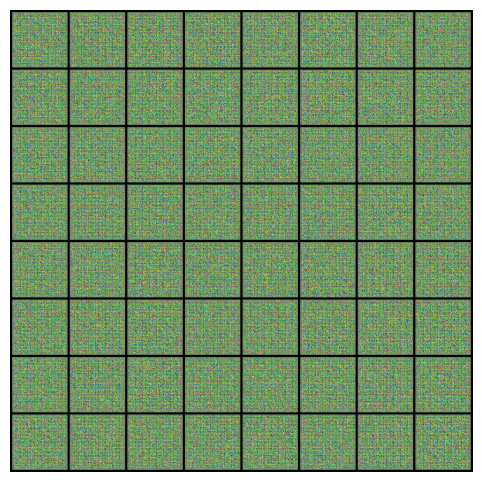

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

latent_size = 128  # Размер скрытого пространства
batch_size = 64  # Размер батча

# Создаем случайный шум
noise = torch.randn(batch_size, latent_size, 1, 1)

# Генерируем изображения с помощью генератора
fake_images = generator(noise)
print(fake_images.shape)
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)

def show_images(images):
    plt.figure(figsize=(12, 6))
    images_grid = vutils.make_grid(images, nrow=int(batch_size**0.5), normalize=True, padding=5)
    plt.imshow(images_grid.permute(1, 2, 0).detach().numpy())
    plt.axis('off')
    plt.show()

show_images(fake_images)

In [ ]:
def fit(model, criterion, epochs, lr, latent_size, batch_size, data_loader, device, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    discriminator.to(device)
    generator.to(device)

    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(), lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []

        for real_images, _ in tqdm(data_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
            real_images = real_images.to(device)

            # Обучаем дискриминатор
            optimizer["discriminator"].zero_grad()

            # Пускаем изначальные изображения в дискриминатор
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Генерируем изображения
            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](noise)

            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images.detach())
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса discriminator'а
            loss_d = real_loss + fake_loss
            loss_d.backward()

            # Обрежем градиенты дляпредотвращения взрыва градиентов
            for group in optimizer["discriminator"].param_groups:
                for param in group['params']:
                    param.grad.data.clamp_(-0.01, 0.01)

            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            # Обучаем генератор
            optimizer["generator"].zero_grad()

            # Генерируем новые изображения
            noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](noise)
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Обновляем веса generator'а
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Выводим точность и лосс на последней эпохе
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Сохранение изображений
        if epoch == epochs - 1:
            save_samples(epoch + start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = fit(model, criterion, epochs = 40, lr = 0.0004, latent_size = latent_size, batch_size = batch_size, data_loader = dataloader, device = device)

Epoch 1/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 11.1981, loss_d: 0.5948, real_score: 0.9565, fake_score: 0.1961


Epoch 2/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 10.1937, loss_d: 0.6929, real_score: 0.9518, fake_score: 0.1245


Epoch 3/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 7.8262, loss_d: 0.7591, real_score: 0.8722, fake_score: 0.1584


Epoch 4/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 6.7258, loss_d: 1.1010, real_score: 0.8483, fake_score: 0.2329


Epoch 5/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 5.9922, loss_d: 1.2674, real_score: 0.7957, fake_score: 0.1757


Epoch 6/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 6.0821, loss_d: 1.0399, real_score: 0.7789, fake_score: 0.1912


Epoch 7/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 6.3292, loss_d: 0.7755, real_score: 0.8618, fake_score: 0.1758


Epoch 8/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 6.9638, loss_d: 0.7745, real_score: 0.8637, fake_score: 0.1494


Epoch 9/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 7.2032, loss_d: 0.5731, real_score: 0.8852, fake_score: 0.1406


Epoch 10/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 7.8852, loss_d: 0.5205, real_score: 0.8847, fake_score: 0.1133


Epoch 11/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 6.8744, loss_d: 0.9721, real_score: 0.8124, fake_score: 0.1644


Epoch 12/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 7.0021, loss_d: 1.0717, real_score: 0.8018, fake_score: 0.1767


Epoch 13/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 6.3163, loss_d: 0.9771, real_score: 0.8247, fake_score: 0.1930


Epoch 14/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 6.8227, loss_d: 0.8832, real_score: 0.8276, fake_score: 0.1877


Epoch 15/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 6.7130, loss_d: 0.8619, real_score: 0.8125, fake_score: 0.1625


Epoch 16/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 7.0976, loss_d: 0.6858, real_score: 0.8249, fake_score: 0.1472


Epoch 17/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 7.2691, loss_d: 1.0702, real_score: 0.7447, fake_score: 0.1866


Epoch 18/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 6.7291, loss_d: 0.8929, real_score: 0.7934, fake_score: 0.1887


Epoch 19/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 6.4721, loss_d: 0.6107, real_score: 0.8519, fake_score: 0.1861


Epoch 20/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 6.8048, loss_d: 0.5656, real_score: 0.8585, fake_score: 0.1550


Epoch 21/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 7.5302, loss_d: 0.7036, real_score: 0.8123, fake_score: 0.1417


Epoch 22/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 7.4893, loss_d: 0.6288, real_score: 0.8380, fake_score: 0.1689


Epoch 23/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 7.7233, loss_d: 0.6375, real_score: 0.8328, fake_score: 0.1496


Epoch 24/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 7.9157, loss_d: 0.5430, real_score: 0.8566, fake_score: 0.1464


Epoch 25/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 7.6788, loss_d: 0.5890, real_score: 0.8512, fake_score: 0.1530


Epoch 26/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 7.4798, loss_d: 0.7620, real_score: 0.8013, fake_score: 0.1668


Epoch 27/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 7.6734, loss_d: 0.4248, real_score: 0.8900, fake_score: 0.1496


Epoch 28/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 7.4562, loss_d: 0.4788, real_score: 0.8587, fake_score: 0.1306


Epoch 29/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 8.0796, loss_d: 0.6874, real_score: 0.8302, fake_score: 0.1627


Epoch 30/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 7.7657, loss_d: 0.5597, real_score: 0.8537, fake_score: 0.1449


Epoch 31/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 7.3393, loss_d: 0.8116, real_score: 0.8135, fake_score: 0.1969


Epoch 32/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 7.1685, loss_d: 0.7780, real_score: 0.8044, fake_score: 0.1913


Epoch 33/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 6.9135, loss_d: 0.8670, real_score: 0.7941, fake_score: 0.2267


Epoch 34/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 6.4317, loss_d: 0.8354, real_score: 0.8039, fake_score: 0.2223


Epoch 35/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 6.4111, loss_d: 0.6700, real_score: 0.8396, fake_score: 0.1845


Epoch 36/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 6.6543, loss_d: 0.7642, real_score: 0.8004, fake_score: 0.2228


Epoch 37/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 6.0280, loss_d: 0.6787, real_score: 0.8176, fake_score: 0.1902


Epoch 38/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 6.3194, loss_d: 0.6646, real_score: 0.8291, fake_score: 0.2010


Epoch 39/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 6.0806, loss_d: 0.6676, real_score: 0.8279, fake_score: 0.1948


Epoch 40/40:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 5.9930, loss_d: 0.5643, real_score: 0.8363, fake_score: 0.1665
Saving generated-images-0040.png


In [19]:
losses_g, losses_d, real_scores, fake_scores = history

In [20]:
epochs = 40
generated_img = cv2.imread(f'./generated/generated-images-00{epochs}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

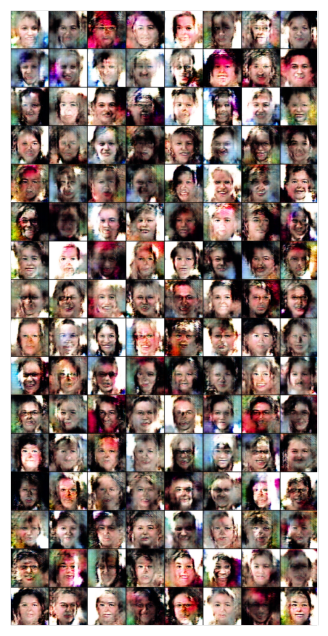

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

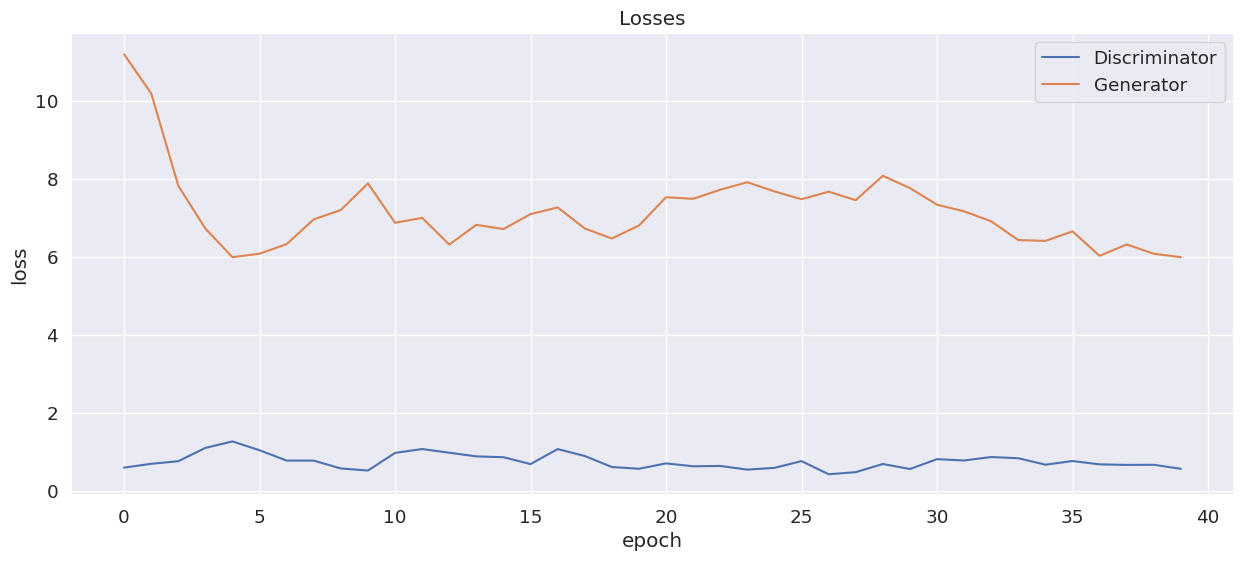

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

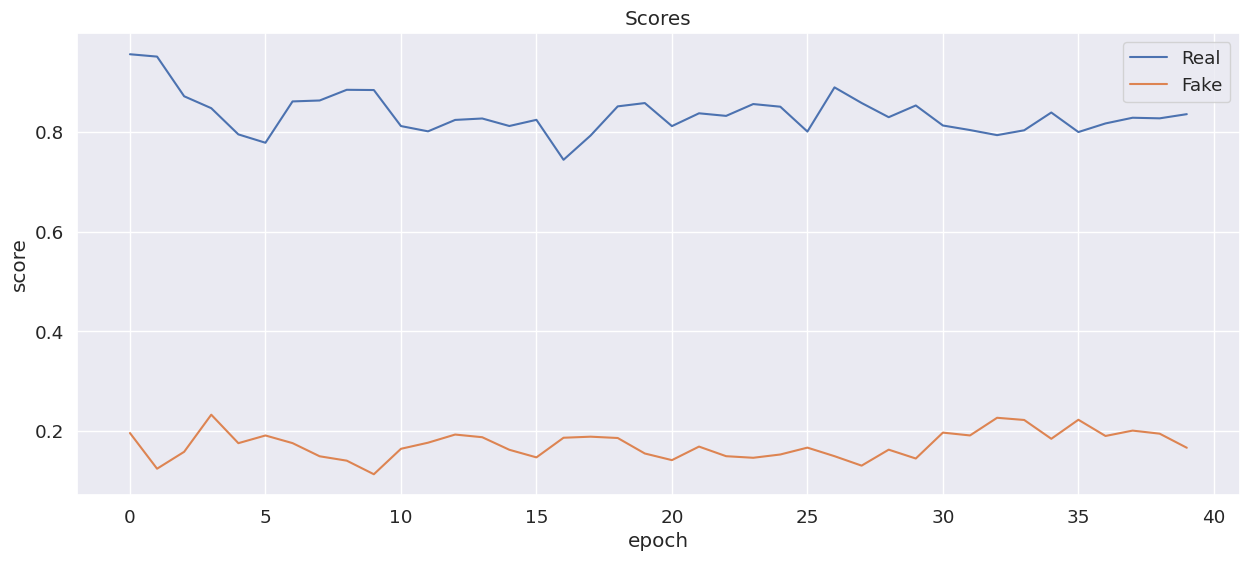

In [23]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

В целом, если бы можно было прикреплять другие обучения этот сид самый плохой из всех, но ввиду того, что у меня закончился лимит на 4 гугл аккаунтов то я пойду дальше =)

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [24]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [25]:
import torchvision.utils as vutils

def show_images(generated):
    # Переносим изображения на CPU для визуализации
    generated = generated.cpu()

    # Создаем сетку изображений
    image_grid = vutils.make_grid(generated, nrow=n_images, normalize=True, padding=5)

    # Выводим изображения с использованием Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(image_grid.permute(1, 2, 0).detach().numpy())
    plt.axis('off')
    plt.show()

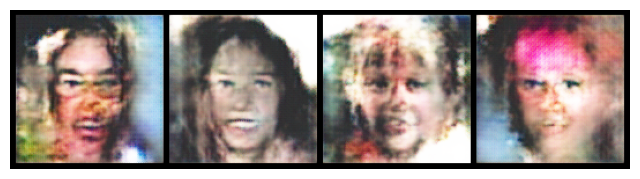

In [26]:
show_images(fake_images)

Как вам качество получившихся изображений?

А вот тут модель меня удивила, я расчитывал на хучший результат, но на удивление картинки выглядят очень хорошо для модели, которая обучалась на 3к фото. Зубы, глаза, подбородок, нос, волосы, брови, все это прослеживается на фотографиях, и если бы мне просто показали эти фотографии и не сказали бы что они сгенерированны нейросетью. То я наверное бы подумал что это какой-то очень крутой художник таким стилем хотел передать нам какую-то очень глубокую мысль =)


## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Генерация фейковых изображений и соответствующих меток
num_fake_images = len(dataloader.dataset)
fake_labels = np.zeros(num_fake_images)  # 0 для фейковых изображений

fake_images = []
for _ in range(num_fake_images // batch_size):
    noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
    generated_batch = model["generator"](noise)
    fake_images.append(generated_batch.cpu().detach())
fake_images = torch.cat(fake_images, dim=0)

# Получение настоящих изображений и их меток
real_images, real_labels = next(iter(dataloader))
real_labels = real_labels.numpy()

# Соединение фейковых и настоящих данных
all_images = torch.cat([fake_images, real_images], dim=0).numpy()
all_labels = np.concatenate([fake_labels, real_labels])

# Преобразование изображений в одномерные векторы
all_images_flat = all_images.reshape(all_images.shape[0], -1)

# Leave-One-Out оценка с KNeighborsClassifier
loo = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

accuracies = []

for train_index, test_index in tqdm(loo.split(all_images_flat), total=len(all_images_flat)):
    X_train, X_test = all_images_flat[train_index], all_images_flat[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Средняя точность по всем итерациям
average_accuracy = np.mean(accuracies)
print(f"Average accuracy: {average_accuracy}")

100%|██████████| 3264/3264 [1:00:53<00:00,  1.12s/it]

Average accuracy: 1.0


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Average accuracy: 1.0 возможно два пути:
1. Я ультрагений, неронная сеть вообще огонь все круто генерит не докопаться
2. К чему я больше склоняюсь я либо неправильно считаю, либо сеть переобучилась

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

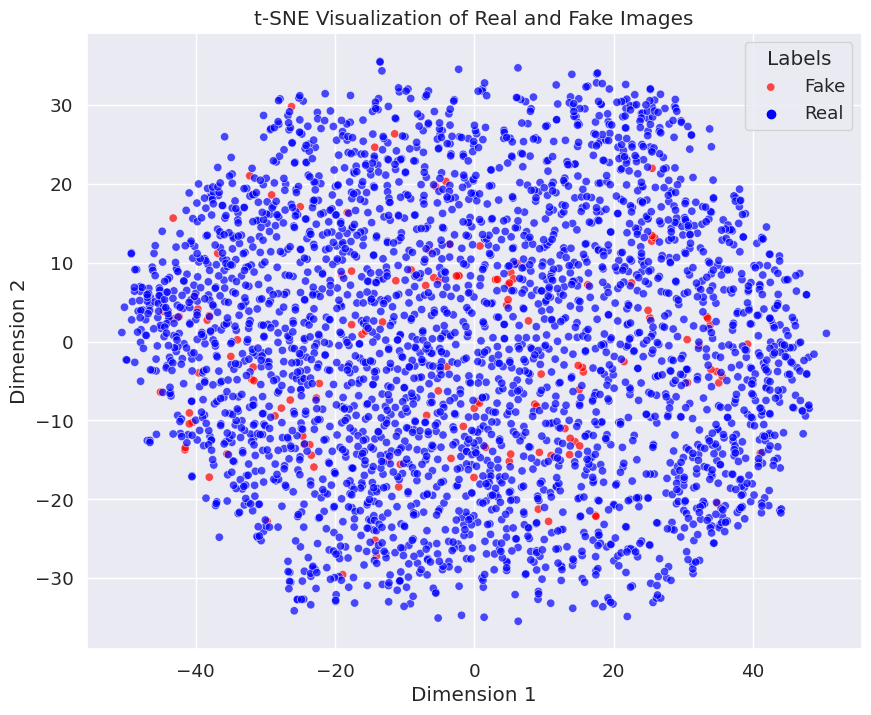

In [31]:
from sklearn.manifold import TSNE
import pandas as pd

# Конкатенация реальных и фейковых данных
real_images, real_labels = next(iter(dataloader))
real_labels = real_labels.numpy()

all_images = torch.cat([fake_images, real_images], dim=0)
all_labels = np.concatenate([fake_labels, real_labels])

# Преобразование данных в одномерные векторы
all_images_flat = all_images.reshape(all_images.shape[0], -1)

# Применение t-SNE для снижения размерности
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_data_flat)

# Создание DataFrame для построения графика
df_tsne = pd.DataFrame(tsne_result, columns=['Dimension 1', 'Dimension 2'])
df_tsne['Labels'] = all_labels

# Построение графика
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Labels', data=df_tsne, palette={0: 'blue', 1: 'red'}, alpha=0.7)
plt.title('t-SNE Visualization of Real and Fake Images')
plt.legend(title='Labels', loc='upper right', labels=['Fake', 'Real'])
plt.show()